## Imports

In [2]:
import operator
import pickle # for saving/loading data and seriliazing models
import re # for regular expressions
from collections import defaultdict, Counter # for counting and advanced dictionaries
from itertools import count # for counting
from typing import List, Dict, Any, Tuple, Union, Optional, Callable # for type hints

import matplotlib.pyplot as plt
import seaborn as sns # for making plots with matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install datasets
from datasets import load_dataset
from nltk.tokenize import sent_tokenize # for tokenizing text into sentences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm # for showing progress bars
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm  # for gradient clipping, to prevent exploding gradients

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00


## Data Preparation

In [3]:
dataset = load_dataset("dair-ai/emotion", "split") # load the dataset, and specify the split version

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
datasets_ =dataset["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
LABEL_ENCODER = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

In [10]:
def create_samples(
    dataset):
    train_samples = [
        (
            train_sample["text"], train_sample["label"],
        )
        for train_sample in dataset["train"]
    ]

    dev_samples = [
        (
            dev_sample["text"], dev_sample["label"]
        )
        for dev_sample in dataset["validation"]
    ]

    return train_samples, dev_samples


def preprocess(data: str):
    out = data.lower()
    out = out.replace("\n", " ").replace("\r", "").replace("\t", " ") # delete newline, tab etc.
    out = re.sub(r"([.,!?;:'\"\(\)\{\}])", r" \1 ", out) # regex to eleminate punctiations etc.
    out = re.sub(r"\s{2,}", " ", out) # eleminate whitespaces
    out = out.replace("_", "") #
    return out

In [13]:
train_samples, dev_samples = create_samples(dataset)

In [14]:
train_samples = list(map(lambda x: (preprocess(x[0]), x[1]), train_samples))
dev_samples = list(map(lambda x: (preprocess(x[0]), x[1]), dev_samples))

## Tokenization

In [18]:
class WordTokenizer:
    def __init__(self) -> None:
        self.start_token = "[START]"
        self.end_token = "[END]"
        self.unk_token = "[UNK]"
        self.pad_token = "[PAD]"

        self.vocab = defaultdict(count().__next__) # indexing dictionary value
        # like a["hello"] -> {"hello": 0}
        self.freq = defaultdict(int)
        self.vocab_size = len(self.vocab)
        self.i2w = {}

        self.__init_special_tokens__()

    def __init_special_tokens__(self) -> None:
        self.vocab[self.start_token]
        self.vocab[self.end_token]
        self.vocab[self.pad_token]
        self.vocab[self.unk_token]

    def insert_token(self, token):
        if token not in self.vocab:
            self.vocab[token]

    def train(self, samples: List[str]) -> None:

        for sample in tqdm(samples):
            sample_splitted = sample.split()
            for token in sample_splitted:
                self.insert_token(token)

        self.vocab_size = len(self.vocab)
        self.i2w = {v: k for k, v in self.vocab.items()} # finding id during inference

    def encode(
        self,
        input_text: Union[str, List],
        max_length: Optional[int] = None,
        preprocessing_function: Callable = lambda x: x,
        exclude_end_token: bool = False
    ) -> Union[List[int], List[List[int]]]:
        input_ids = []

        if type(input_text) == str:
            input_text = preprocessing_function(input_text)
            input_text_splitted = input_text.split() # splitted based on whitespaces

            input_ids.append(self.vocab.get(self.start_token)) # add start token
            for token in input_text_splitted:
                input_ids.append(self.vocab.get(token, self.vocab.get(self.unk_token))) # if token exists get token, otherwise get unk_token
                if max_length is not None and max_length - 1 == len(input_ids): # for end token we give place
                    break

            if not exclude_end_token:
                input_ids.append(self.vocab.get(self.end_token)) # add end token

            if max_length is not None and len(input_ids) < max_length: # padding
                input_ids.extend(
                    [self.vocab.get(self.pad_token) for _ in range(len(input_ids), max_length)]
                )

        else:
            input_text = list(map(lambda x: preprocessing_function(x), input_text))
            for each_input_text in input_text:
                each_input_ids = []
                each_input_text_splitted = each_input_text.split() # we iterate through their tokens
                for token in each_input_text_splitted:
                    each_input_ids.append(self.vocab.get(token, self.vocab.get(self.unk_token)))
                    if max_length is not None and max_length - 1 == len(each_input_ids): # for end token we give place
                        break

                    if not exclude_end_token:
                        each_input_ids.append(self.vocab.get(self.end_token))

                    if max_length is not None and len(each_input_ids) < max_length:
                        each_input_ids.extend(
                            [self.vocab.get(self.pad_token) for _ in range(len(each_input_ids), max_length)]
                        )
                input_ids.append(each_input_ids)

        return input_ids

    def decode(
        self, input_ids: Union[List[int], List[List[int]]]
    ) -> Union[str, List[str]]:
        decoded_string = []

        if type(input_ids) == list and type(input_ids[0]) == int:
            for id in input_ids:
                decoded_string.append(self.i2w.get(id)) # decoding via i2w

        else:
            for each_input_id in input_ids:
                decoded_string_each = []
                for id in each_input_id:
                    decoded_string_each.append(self.i2w.get(id))
                decoded_string_each.append(decoded_string_each)

        return decoded_string

    def save(self, output_file="model/word.tokenizer"):
        with open(output_file, 'wb') as f:
            pickle.dump(self, f) # self helps us to call function like .save()

    @staticmethod
    def load(output_file="model/word.tokenizer"):
        with open(output_file, "rb") as f:
            tokenizer = pickle.load(f)
        return tokenizer

In [19]:
train_samples_to_be_tokenized = [train_sample[0] for train_sample in train_samples]
tokenizer = WordTokenizer()
tokenizer.train(train_samples_to_be_tokenized)

  0%|          | 0/16000 [00:00<?, ?it/s]

In [24]:
tokenizer.save()

defaultdict(<method-wrapper '__next__' of itertools.count object at 0x78ebac588bc0>,
            {'[START]': 0,
             '[END]': 1,
             '[PAD]': 2,
             '[UNK]': 3,
             'i': 4,
             'didnt': 5,
             'feel': 6,
             'humiliated': 7,
             'can': 8,
             'go': 9,
             'from': 10,
             'feeling': 11,
             'so': 12,
             'hopeless': 13,
             'to': 14,
             'damned': 15,
             'hopeful': 16,
             'just': 17,
             'being': 18,
             'around': 19,
             'someone': 20,
             'who': 21,
             'cares': 22,
             'and': 23,
             'is': 24,
             'awake': 25,
             'im': 26,
             'grabbing': 27,
             'a': 28,
             'minute': 29,
             'post': 30,
             'greedy': 31,
             'wrong': 32,
             'am': 33,
             'ever': 34,
             'nostalgic': 35,

In [21]:
lengths = [len(tokenizer.encode(sample)) for sample in train_samples_to_be_tokenized]

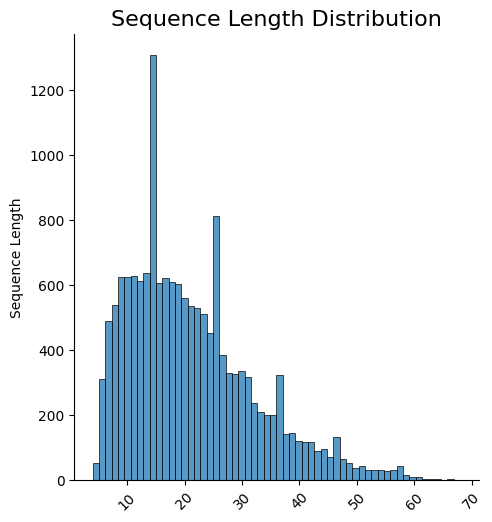

In [22]:
sns.displot(lengths)
plt.title("Sequence Length Distribution", fontsize=16)
plt.ylabel("Sequence Length")
plt.xticks(rotation=45)
plt.show()

In [23]:
max_length = 64

## DataLoaders

In [25]:
class SentenceSampler(Dataset):
    def __init__(
        self, tokenizer: WordTokenizer, samples: List[str], max_length: int
    ) -> None:
        self.tokenizer = tokenizer
        self.samples = samples
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]: # random index for batch
        sentence = self.samples[idx][0]
        target = self.samples[idx][1]
        input_ids = self.tokenizer.encode(sentence, self.max_length)

        return {
            "input_ids": torch.LongTensor(input_ids),
            "target": torch.Tensor([target])
        }

In [26]:
train_dataset = SentenceSampler(tokenizer, train_samples, max_length=128)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

dev_dataset = SentenceSampler(tokenizer, dev_samples, max_length=128)
dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=False)

In [29]:
def test():
    for batch in train_dataloader:
        print(tokenizer.decode(batch["input_ids"][0].tolist()))
        print(batch["target"][0].tolist())
        break

test()

['[START]', 'i', 'like', 'to', 'feel', 'respected', 'by', 'a', 'guy', 'i', 'm', 'with', 'not', 'abused', '[END]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

## Modeling

In [30]:
class RNNClassifier(nn.Module):
    def __init__(
        self, n_classes: int, vocab_size: int, num_layers, embedding_size: int,
        embedding_dropout_rate: float, hidden_size: int, bidirectional
    ) -> None:
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.embedding_dropout = nn.Dropout(embedding_dropout_rate)

        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            bidirectional=bidirectional,
            num_layers=num_layers,
            batch_first=True
        )

        self.classifier = nn.Linear(
            in_features=hidden_size*2 if bidirectional else hidden_size,
            out_features=n_classes
        )

        self.gelu = nn.GELU()

    def forward(self, token_ids):
        # token_ids: [B, max_seq_len]
        out = self.embedding_dropout(self.embedding(token_ids))
        # out: [B, max_seq_len, embed_dim]
        out, (hidden, cell) = self.lstm(out)
        # out: [B, max_seq_len, hidden_size]
        hidden, cell = None, None
        out = out[:, 0, :]
        # out: [B, hidden_size]
        out = self.gelu(out)
        return self.classifier(out)
        # return: [B, max_seq_len, vocab_size]

## Training

In [36]:
target_counts = list(Counter([sample[1] for sample in dev_samples]).values())
class_weights = [1-(target_count)/sum(target_counts) for target_count in target_counts]
print(target_counts)
print(class_weights)
# criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to("mps"))
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weights).to("cpu"))


[550, 178, 275, 704, 212, 81]
[0.725, 0.911, 0.8625, 0.648, 0.894, 0.9595]


In [37]:
class TrainerWrapper:
    def __init__(
            self, model: RNNClassifier, device: torch.device,
            norm_threshold: Optional[float] = None
    ):
        self.model = model
        self.device = device
        self.model = self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.scheduler = None#torch.optim.lr_scheduler.StepLR(self.optimizer, step_size = 10, gamma = 0.1)
        self.norm_threshold = norm_threshold

    def train(self, train_dataloader, dev_dataloader, epochs, tokenizer, criterion):
        total = len(train_dataloader) * epochs

        with tqdm(total=total, desc="Training Round") as training:
            for epoch in range(epochs):
                train_loss = 0
                batch_count = 0

                train_preds = []
                train_ground_truths = []
                for step, batch in enumerate(train_dataloader):
                    self.model.train()

                    input_ids = batch["input_ids"].to(self.device)
                    targets = batch["target"].to(self.device).squeeze(1)

                    out = self.model(input_ids.long())
                    loss = criterion(out, targets.long())

                    loss.backward()
                    clip_grad_norm(model.parameters(), 0.7)

                    # if grad_acc_step: --> If optimal batch_size = 32 and computer not that good, it will sum up the gradients then calculate after 32th
                    #   self.optimizer.step()
                    #   self.optimizer.zero_grad()
                    #   grad_acc_step += 1
                    # else:
                    #   grad_acc_step = 1

                    self.optimizer.step()

                    train_loss += loss.item()
                    batch_count += 1

                    preds = (
                        out.softmax(dim=-1)
                            .argmax(dim=-1)
                            .flatten()
                            .detach()
                            .cpu()
                            .tolist()
                    )
                    ground_truth = targets.detach().cpu().tolist()
                    train_preds.extend(preds)
                    train_ground_truths.extend(ground_truth)

                    training.update()

                dev_loss, dev_accuracy, dev_f1 = self.evaluate(
                    dev_dataloader=dev_dataloader,
                    tokenizer=tokenizer,
                    criterion=criterion
                )

                train_accuracy = accuracy_score(train_ground_truths, train_preds)
                train_f1 = f1_score(train_ground_truths, train_preds, average="macro")

                print(35*"*")
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"  - Train Loss: {train_loss/batch_count}")
                print(f"  - Train Accuracy: {train_accuracy}")
                print(f"  - Train F1: {train_f1}")
                print(f"  - Eval Loss: {dev_loss}")
                print(f"  - Eval Accuracy: {dev_accuracy}")
                print(f"  - Eval F1: {dev_f1}")
                if self.scheduler is not None:
                    self.scheduler.step()

    @torch.no_grad()
    def evaluate(self, dev_dataloader, tokenizer, criterion):
        self.model = self.model.to(self.device)
        total = len(dev_dataloader)

        dev_loss = 0
        batch_count = 0

        dev_preds = []
        dev_ground_truths = []

        with tqdm(total=total, desc="Evaluation Round") as evaluation:
            for step, batch in enumerate(dev_dataloader):
                self.model.eval()
                input_ids = batch["input_ids"].to(self.device)
                targets = batch["target"].to(self.device).squeeze(1)

                out = self.model(input_ids.long())
                loss = criterion(out, targets.long())

                dev_loss += loss.item()
                batch_count += 1

                preds = (
                    out.softmax(dim=-1)
                        .argmax(dim=-1)
                        .flatten()
                        .detach()
                        .cpu()
                        .tolist()
                )
                ground_truth = targets.detach().cpu().tolist()
                dev_preds.extend(preds)
                dev_ground_truths.extend(ground_truth)

                evaluation.update()

        dev_accuracy = accuracy_score(dev_ground_truths, dev_preds)
        dev_f1 = f1_score(dev_ground_truths, dev_preds, average="macro")

        return dev_loss/batch_count, dev_accuracy, dev_f1

In [38]:
model = RNNClassifier(len(LABEL_ENCODER), tokenizer.vocab_size, 1, 256, 0.1, 512, True)

In [39]:
trainer = TrainerWrapper(model, torch.device("cpu"))

In [ ]:
trainer.train(train_dataloader, dev_dataloader, 20, tokenizer, criterion)

Training Round:   0%|          | 0/2500 [00:00<?, ?it/s]

<ipython-input-37-5a264f2b966b>:34: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  clip_grad_norm(model.parameters(), 0.7)


Evaluation Round:   0%|          | 0/32 [00:00<?, ?it/s]

***********************************
Epoch 1/20
  - Train Loss: 1.5661593494415282
  - Train Accuracy: 0.3524375
  - Train F1: 0.13922161084944104
  - Eval Loss: 1.613019835203886
  - Eval Accuracy: 0.3755
  - Eval F1: 0.1297855511302377


<ipython-input-37-5a264f2b966b>:34: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  clip_grad_norm(model.parameters(), 0.7)


Evaluation Round:   0%|          | 0/32 [00:00<?, ?it/s]

***********************************
Epoch 2/20
  - Train Loss: 1.0649795536994935
  - Train Accuracy: 0.5929375
  - Train F1: 0.3609985932875754
  - Eval Loss: 0.7138923369348049
  - Eval Accuracy: 0.721
  - Eval F1: 0.5332339295993794


<ipython-input-37-5a264f2b966b>:34: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  clip_grad_norm(model.parameters(), 0.7)


Evaluation Round:   0%|          | 0/32 [00:00<?, ?it/s]

***********************************
Epoch 3/20
  - Train Loss: 0.42556617844104766
  - Train Accuracy: 0.8474375
  - Train F1: 0.7806875608936261
  - Eval Loss: 0.32611076021566987
  - Eval Accuracy: 0.8905
  - Eval F1: 0.859596553664845


<ipython-input-37-5a264f2b966b>:34: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  clip_grad_norm(model.parameters(), 0.7)


Evaluation Round:   0%|          | 0/32 [00:00<?, ?it/s]

***********************************
Epoch 4/20
  - Train Loss: 0.21325032085180282
  - Train Accuracy: 0.920625
  - Train F1: 0.8864308679632678
  - Eval Loss: 0.2341558646876365
  - Eval Accuracy: 0.917
  - Eval F1: 0.8905859664700829


<ipython-input-37-5a264f2b966b>:34: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  clip_grad_norm(model.parameters(), 0.7)


In [ ]:
torch.save(trainer.model.state_dict(), "model/model_emotion.pt")

## Load and Play

In [ ]:
def inference(model, tokenizer, input_string):
    input_ids = tokenizer.encode(input_string, None)
    print(" ".join(tokenizer.decode(input_ids)))
    input_ids = torch.Tensor(input_ids)[None, ...]

    out = model(input_ids.long())
    pred = out.softmax(dim=-1).argmax(dim=-1).flatten().item()
    return pred, out[0].softmax(dim=-1)

In [ ]:
model = RNNClassifier(len(LABEL_ENCODER), tokenizer.vocab_size, 1, 256, 0.1, 512, True)

In [ ]:
model.load_state_dict(torch.load("model/model_emotion.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
tokenizer = WordTokenizer.load()

In [ ]:
input_string = """
i am pissed
"""

emotion, probabilities = inference(
    model, tokenizer,
    input_string=input_string
)
print(LABEL_ENCODER[emotion])


[START] i am pissed [END]
anger
